# ECE324: Assignment 4

## Submission

* `assign4.pdf`: PDF with written answers to the assignment's questions.
* `assign2.ipynb`: Notebook with code to produce results.
* `MyBest.pt` and `MyBestSmall.pt`: Trained model parameter and hyperparameter files.

In [1]:
##############
# IMPORT BOX #
##############

import matplotlib.pyplot as plt 
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

## 1: Introduction

Based in large part on the PyTorch [CIFAR-10 Dataset](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

- [x] Get an instance of the code from that tutorial running locally.

**See `CNN_Tutorial.ipynb`**

## 2: Input Dataset

We make use of the [torchvision](https://pytorch.org/docs/stable/torchvision/index.html) module. There are two important classes:

### `torchvision.transforms`
* Convert image file into a tensor using `transforms.ToTensor`.
* Normalize the image using `transforms.Normalize`.

`transforms.Compose` does these two things together?

### `torchvision.datasets.ImageFolder`
* Builds a `dataset` object from folders arranged on computer.
* You just point it to the folder containing folders `A`-`K`.
* You can have it invoke the composite transformation described above, too.

- [x] Set all of this up and use the `dataloader` object to retrieve **four** images and display them.

- [x] Print out the 4 images with their ground-truth values and put this into the PDF. 

In [2]:
# Defining the transform: (1) ToTensor, (2) Normalize.
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Building a dataset object from the local dataset directory:
dataset_personal = torchvision.datasets.ImageFolder('./personal_data/', transform=transform)

# Building a loader object (full dataset)
dataloader_personal = torch.utils.data.DataLoader(dataset_personal, batch_size=4, shuffle=True, num_workers=1)

classes = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K')

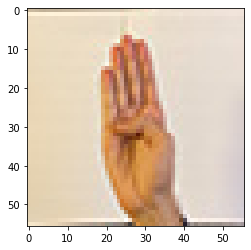

In [3]:
# Testing the dataset
data, label = dataset_personal.__getitem__(5)

data.shape

# Visualizing some Images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(data)

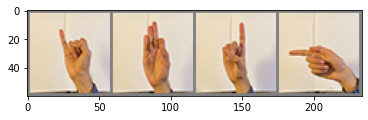

    I     F     D     G


In [4]:
# get some random training images
dataiter = iter(dataloader_personal)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 3: Model Building and Testing

Make a CNN with: 
- [ ] Two convolutional layers (with ReLU activation function).
    - [x] 1st conv: 4 kernels of size 3x3, stride=1.
    - [x] 2nd conv: 8 kernels of size 5x5, stride=1.
    - [x] Each conv layer followed by **max pool(2,2)**.
- [x] Two fully-connected layers.
    - [x] Layer 1: 100 neurons.
    - [x] Layer 2: Determine by yourself.
- [ ] Write a training loop using **only your** data, training to the point of overfitting.
    - [x] MSELoss.
    - [x] SGD.
    - [x] Batch Size = 10.
    - [x] LR = 0.01.
    - [x] Epochs = 100 (increase enough to achieve perfect accuracy).
    - [x] Give `random` a specific value so code is deterministic (`torch.manual_seed(seed)`).
   
General approach of ensuring that a NN can 'memorize' a small dataset is to be used for ALL datascience problems that use NN's.

**In Final PDF:**
- [ ] Produce plots of loss and accuracy (on training data only) vs. epoch.
- [ ] Execution time for full training loop (using `time` library).
- [ ] Number of epochs to get perfect training accuracy.
- [ ] Size of network:
    - Number of params.
    - Computer memory to store all parameters (weights + biases) using `torchsummary` library (installed from [here](https://github.com/sksq96/pytorch-summary)).

In [5]:
#########################################
# Defining the Neural Network Structure #
#########################################

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 4, 3) # 3 = num channels in input image (RGB); 4 = number of kernels; 4 = size of the kernel (4x4); 
                                        # NOTE: There is no padding by default. Stride is, by default, 1.
        self.pool = nn.MaxPool2d(2,2) # 2 = max pool of size 2x2; 2 = stride is 2;

        self.conv2 = nn.Conv2d(4, 8, 5) # 8 kernels of size 5x5

        self.fc1 = nn.Linear(8*11*11, 100)
        self.fc2 = nn.Linear(100, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 8*11*11) # Reshapes the 16x5x5 tensor into a 400-long tensor. 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        # Note: input is a 4D tensor batch (Nx32x32x3)
net = Net()

In [6]:
###################################################################
# Defining Loss, Optimizer, and New Dataloader with Batch Size 10 #
###################################################################

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

# Building a loader object (full dataset) with new batch size = 10
dataloader_personal = torch.utils.data.DataLoader(dataset_personal, batch_size=10, shuffle=True, num_workers=1)

num_epochs = 100
random_seed = 1234

torch.manual_seed(random_seed)

In [9]:
#################
# Training Loop #
#################

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader_personal, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.float()

        # print('Input dtype: {}; \tlabel dtype: {}'.format(inputs.dtype, labels.dtype))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.float()).float()
        loss = criterion(outputs, labels)

        # print('Outputs datatype: {}'.format(outputs.dtype))
        # print('labels datatype: {}'.format(labels.dtype))
        # print('loss datatype: {}'.format(loss.dtype))

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # if i % 3 == 2 or True:    # print every 2000 mini-batches
        if i == 0:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
            running_loss = 0.0

print('Finished Training')


[1,     1] loss: 27.103
[2,     1] loss: 19.224
[3,     1] loss: 25.831
[4,     1] loss: 20.007
[5,     1] loss: 12.429
[6,     1] loss: 10.098
[7,     1] loss: 9.369
[8,     1] loss: 5.542
[9,     1] loss: 16.174
[10,     1] loss: 8.817
[11,     1] loss: 8.195
[12,     1] loss: 9.155
[13,     1] loss: 9.023
[14,     1] loss: 4.952
[15,     1] loss: 5.991
[16,     1] loss: 4.765
[17,     1] loss: 9.196
[18,     1] loss: 6.888
[19,     1] loss: 7.836
[20,     1] loss: 10.612
[21,     1] loss: 8.158
[22,     1] loss: 8.800
[23,     1] loss: 5.928
[24,     1] loss: 5.246
[25,     1] loss: 9.687
[26,     1] loss: 7.256
[27,     1] loss: 6.841
[28,     1] loss: 12.584
[29,     1] loss: 8.175
[30,     1] loss: 13.059
[31,     1] loss: 9.159
[32,     1] loss: 8.799
[33,     1] loss: 8.414
[34,     1] loss: 5.863
[35,     1] loss: 8.848
[36,     1] loss: 6.400
[37,     1] loss: 9.396
[38,     1] loss: 11.344
[39,     1] loss: 8.590
[40,     1] loss: 10.502
[41,     1] loss: 8.293
[42,     1] l

## 4: Using Full Dataset

### 4.1: Data Loading and Splitting

Decide on whether to include on of each person's data in the training + validation set (answer: no). Answer the following questions in the PDF:

- [ ] Which 'method' (one of each vs. some with none) is better for training/validation split w.r.t different people's data?
- [ ] What fraction train/validation split did you use? Why?
- [ ] Report `mean` and `stdev` of training data used.

### 4.2: Hyperparameters

Hyperparameter list:

1. Number of conv layers.
2. Kernels on each layer.
3. Size of kernels (standardized across all kernels).
4. Activation function.
5. Number of fully connected layers.
6. Number of neurons on each fully connected layer (except for final one).
7. Learning rate.
8. Batch size.
9. Loss function.
10. Optimizer.
11. Use of batch normalization.

### 4.3: Hyperparameter Search

Fix the following hyperparameters:

* ReLU Activation Function
* Optimizer: SGD
* Batch Normalization: no
* Loss Function: MSELoss
* Size of kernels on each conv layer: 3x3
* Number of fully-connected layers: 2

Use the following ranges for remaining hyperparameters:

1. Conv layers $\in \{1, 2, 4\}$
2. Kernels on each layer $\in \{10, 30\}$
3. Number of neurons on first layer: $\in \{8, 32\}$
4. Learning rate: $\in \{.1, .01\}$
5. Batch size: $\in \{4, 32\}$

- [ ] Now select $12$ combinations you think are best to train on and explain why you chose them.
- [ ] Present the following results for each:
    - [ ] Validation accuracy.
    - [ ] Training execution time.
    - [ ] Number of epochs to train (how long until training is no longer improving validation accuracy?)
    - [ ] Number of parameters in the network.
    - [ ] Amount of memory space required to hold parameters.
- [ ] Comment on relative merits of different networks w.r.t these metrics.

- [ ] Select a 'best network' and provide loss and accuracy vs. epoch plots on **training and validation datasets**.

## 5: Batch Normalization and Cross Entropy Loss Function

For the best network from previous section, create three new versions:

1. Adding batch normalization on convolutional layers AND fully-connected layers.
2. Replaces MSELoss with Cross-Entropy Loss.
3. Uses batch normalization AND cross-entropy loss.

- [ ] Give all the same metrics reported above in a table.
- [ ] Provide loss and accuracy plots for training + validation data.
- [ ] Describe effects of the changes on the results.

## 6: Final Best Networks and Confusion Matrix

### 6.1: Find the Best One.

- [ ] Explore + find best network (no rules except not using pre-trained network). 
- [ ] Store trained parameters of accurate network using `torch.save(model.state_dict(), 'MyBest.pt')`.
- [ ] Submit this on Quercus. Indicate which model code files the params are from. Provide hyperparameter settings used to creat them.

### 6.2: Most Accurate Small Network

- [ ] Find network that works best with **less than 5000** trainable params.
    - [ ] Measure params with `torchsummary` library.
- [ ] Include full output from summary function.
- [ ] Provide params in `MyBestSmall.pt`, indicate which model its for.



### 6.3: Final Questions

- [ ] For most accurate network, provide `confusion matrix`.
- [ ] Use `sklearn`'s `confusion_matrix` function.